In [5]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time
from google.colab import files
import pickle
import pydrive


In [6]:
# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


4422102/4422102 [==============================] - 1s 0us/step


In [7]:
x_train = x_train/255.0
x_test = x_test/255.0


In [8]:
# Convert grayscale to RGB
x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test_rgb = np.repeat(x_test[..., np.newaxis], 3, -1)


In [9]:
# Resize images to a smaller size
target_size = (32, 32)
x_train_resized = np.array([img_to_array(array_to_img(img).resize(target_size)) for img in x_train_rgb])
x_test_resized = np.array([img_to_array(array_to_img(img).resize(target_size)) for img in x_test_rgb])

In [10]:
# Preprocess input and convert labels to categorical
x_train_preprocessed = preprocess_input(x_train_resized)
x_test_preprocessed = preprocess_input(x_test_resized)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
# Creating a data augmentation generator
datagen = ImageDataGenerator(
    rotation_range = 0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)


In [12]:
# Fitting the data augmentation generator to the training data
datagen.fit(x_train_preprocessed)


In [13]:
# Create the model
resnet_model = Sequential()
pretrained_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))


94765736/94765736 [==============================] - 3s 0us/step


In [14]:
for layer in pretrained_model.layers:
    layer.trainable = True

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(10, activation='softmax'))


In [15]:
resnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24,641,930
Trainable params: 24,588,810
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
# Compile and train the model
resnet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 30
batch_size = 64

In [17]:
history = resnet_model.fit(
    x_train_preprocessed,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test_preprocessed, y_test)
)

Epoch 1/30
938/938 [==============================] - 99s 50ms/step - loss: 1.0630 - accuracy: 0.6572 - val_loss: 0.5744 - val_accuracy: 0.8056
Epoch 2/30
938/938 [==============================] - 46s 49ms/step - loss: 0.4784 - accuracy: 0.8333 - val_loss: 0.4340 - val_accuracy: 0.8479
Epoch 3/30
938/938 [==============================] - 58s 61ms/step - loss: 0.3630 - accuracy: 0.8714 - val_loss: 0.3793 - val_accuracy: 0.8671
Epoch 4/30
938/938 [==============================] - 60s 64ms/step - loss: 0.2971 - accuracy: 0.8927 - val_loss: 0.3596 - val_accuracy: 0.8729
Epoch 5/30
938/938 [==============================] - 50s 53ms/step - loss: 0.2511 - accuracy: 0.9081 - val_loss: 0.3355 - val_accuracy: 0.8865
Epoch 6/30
938/938 [==============================] - 49s 52ms/step - loss: 0.2115 - accuracy: 0.9219 - val_loss: 0.3314 - val_accuracy: 0.8869
Epoch 7/30
938/938 [==============================] - 45s 48ms/step - loss: 0.1837 - accuracy: 0.9334 - val_loss: 0.3240 - val_accuracy:

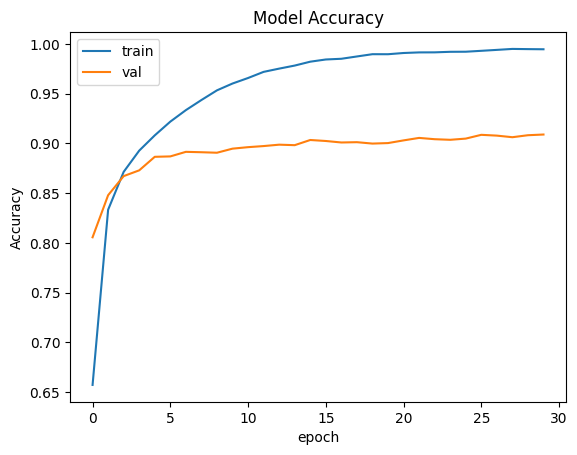

In [18]:
# Accuracy vs Epoch plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

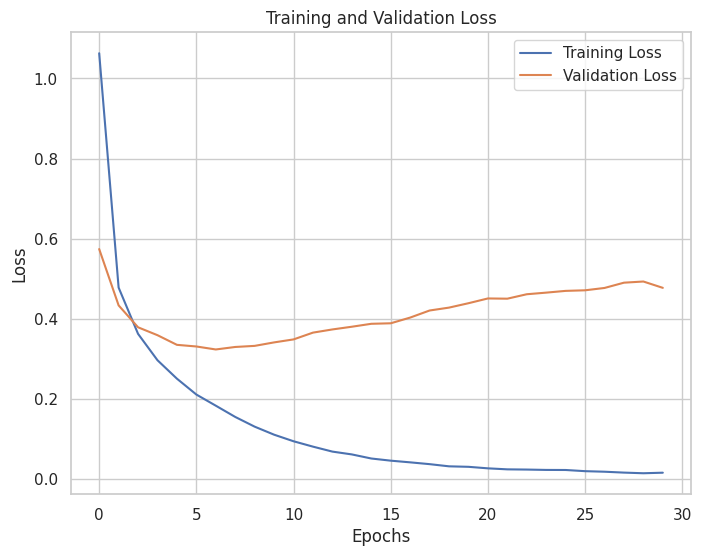

In [20]:
# Plot training and validation loss
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 [==============================] - 5s 12ms/step


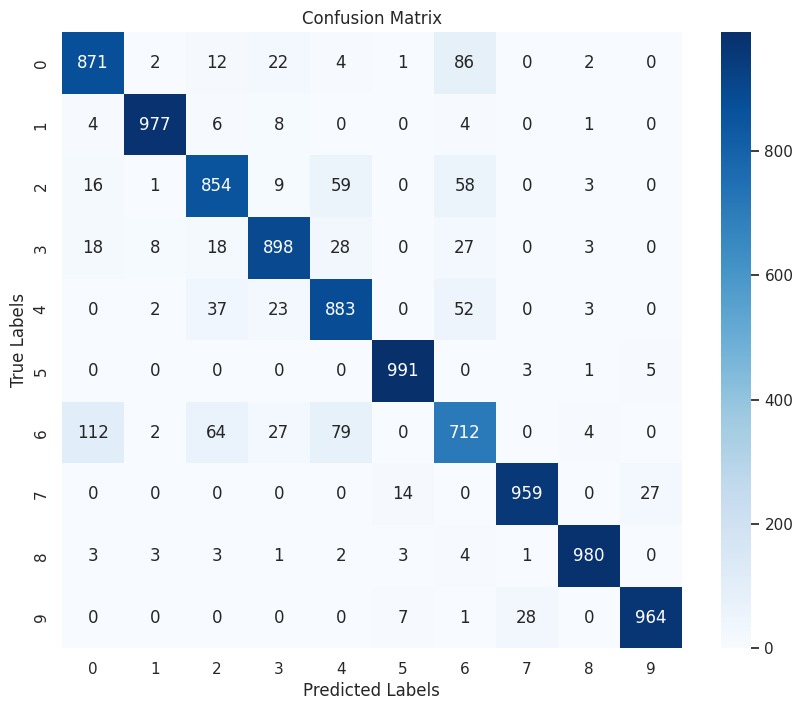

In [21]:

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(resnet_model.predict(x_test_preprocessed), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 0s 450ms/step


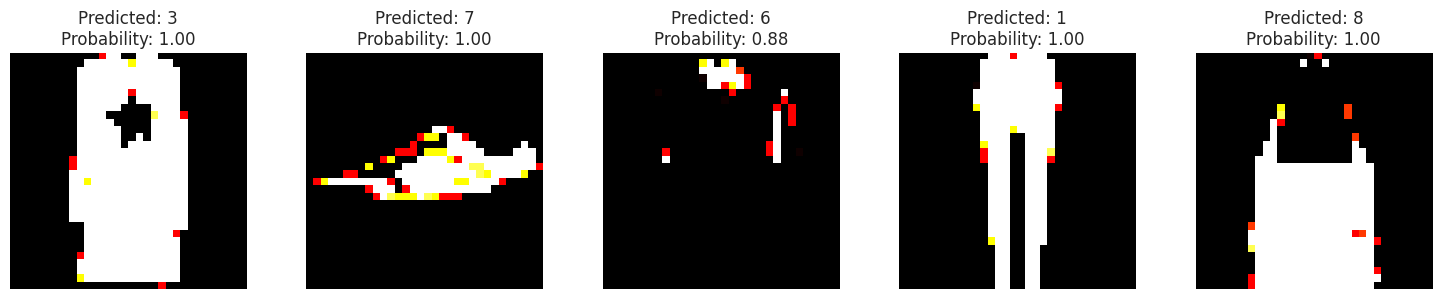

In [22]:
# Testing with random test samples
num_samples = 5
random_indices = np.random.choice(len(x_test_preprocessed), num_samples, replace=False)
x_samples = x_test_preprocessed[random_indices]
y_true_samples = y_test[random_indices]

# Make predictions
y_pred_samples = resnet_model.predict(x_samples)
predicted_labels = np.argmax(y_pred_samples, axis=1)
probabilities = np.max(y_pred_samples, axis=1)

# Visualize the samples and predictions
fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(15, 3))

for i in range(num_samples):
    axes[i].imshow(x_samples[i])
    axes[i].axis('off')
    axes[i].set_title(f"Predicted: {predicted_labels[i]}\nProbability: {probabilities[i]:.2f}")

plt.tight_layout()
plt.show()

In [23]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [24]:
# Printing the class labels
for i, class_name in enumerate(class_names):
    print(f"Class {i}: {class_name}")

Class 0: T-shirt/top
Class 1: Trouser
Class 2: Pullover
Class 3: Dress
Class 4: Coat
Class 5: Sandal
Class 6: Shirt
Class 7: Sneaker
Class 8: Bag
Class 9: Ankle boot


In [25]:

# Start the timer.
start_time = time.time()

# Running the inference on the VGG19 model for each image.
x_test_preprocessed1 = np.expand_dims(x_test_preprocessed, axis=0) # Add a batch dimension to the input images.
for image in x_test_preprocessed1 :
    prediction = resnet_model.predict(image)

# Stopping the timer.
end_time = time.time()

# Calculateing  average inference latency.
average_latency = (end_time - start_time) / len(x_test_preprocessed1)

print("Average inference latency: {} milliseconds".format(average_latency))


313/313 [==============================] - 3s 9ms/step
Average inference latency: 3.522426128387451 milliseconds


In [26]:
#calculating the overall testing accuracy
resnet_model.evaluate(x_test_preprocessed, y_test)


313/313 [==============================] - 4s 12ms/step - loss: 0.4777 - accuracy: 0.9089


[0.47772857546806335, 0.9089000225067139]

In [27]:
# Saving the model using pickle
with open('resnet.pkl', 'wb') as f:
    pickle.dump(resnet_model, f)


In [28]:
#downloading the model
files.download('resnet.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>